In [1]:
import numpy as np
from stateinterpreter import Classifier, identify_metastable_states, load_dataframe, descriptors_from_traj, sample
from stateinterpreter.plot import plot_states
#Paranoia
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

Helper functions to define groups.

In [2]:
kBT = 2.5
BPTI_data_path = '../../../data/md_datasets/BPTI-unbiased/'
colvar_file = BPTI_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : BPTI_data_path+'all_trj_10ns.trr',
        'topology' : BPTI_data_path+'bpti-protein.pdb'
    }
#Load Descriptors
#desc_path = '../../../data/md_datasets/BPTI-unbiased/descritpors.pkl'
#descriptors = pd.read_pickle(desc_path)
colvar = load_dataframe(colvar_file).drop(['idx', 'time'], axis=1)

In [3]:
descriptors, feats_info = descriptors_from_traj(traj_dict, descriptors=['hbonds_contacts'])

Computing Hydrogen bonds contacts
Donors: [0, 7, 9, 10, 40, 52, 72, 82, 101, 144, 155, 165, 170, 179, 200, 210, 218, 232, 242, 249, 251, 252, 266, 285, 304, 311, 313, 314, 328, 339, 349, 369, 380, 390, 397, 404, 414, 422, 436, 446, 453, 472, 482, 490, 499, 504, 513, 533, 549, 560, 570, 577, 584, 594, 601, 603, 604, 618, 628, 636, 650, 657, 659, 660, 674, 681, 688, 695, 702, 722, 730, 744, 749, 755, 765, 780, 792, 802, 819, 826, 828, 829, 843, 848, 857, 867, 874, 881]
Acceptors: [  0   3   7   9  10  26  29  40  43  46  47  52  55  72  75  82  85 101
 104 108 109 116 119 130 133 144 147 155 165 168 170 179 182 186 189 200
 203 210 213 218 232 235 242 245 249 251 252 266 269 285 288 304 307 311
 313 314 328 331 339 349 352 369 372 380 390 393 396 397 404 407 414 417
 422 436 439 446 449 453 456 472 475 482 485 489 490 499 502 504 513 516
 533 536 549 552 560 570 573 577 580 584 587 594 597 601 603 604 618 621
 628 631 636 650 653 657 659 660 674 677 680 681 688 691 694 695 702 705
 722 7

In [4]:
cv_list = ['tica1', 'tica2']
kBT = 2.5
states_labels = identify_metastable_states(colvar, cv_list, kBT, bw_method=0.2, fes_cutoff=kBT)

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 4 local minima with selected populations:
	Basin 0 -> 25685 configurations.
	Basin 1 -> 69759 configurations.
	Basin 2 -> 1207 configurations.
	Basin 3 -> 798 configurations.


(<Figure size 480x400 with 1 Axes>,
 <AxesSubplot:title={'center':'Metastable states identification'}, xlabel='tica1', ylabel='tica2'>)

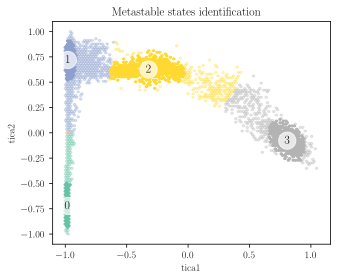

In [15]:
plot_states(colvar, states_labels, cv_list, fes_isolines = False)

In [12]:
#regularizers = np.geomspace(0.1, 10, 12)
regularizers = 10**(-0.5)
#select_feat = 'sin_|cos_'
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 100, states_subset=[0,1], states_names=["Low", 'Hi'])
groups = [feats_info[name]['group'] for name in features_names]
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 1000, groups=groups)

Optimizing Lasso Estimator:   0%|          | 0/1 [00:00<?, ?it/s]/home/novelli/anaconda3/lib/python3.8/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(
Optimizing Lasso Estimator: 100%|██████████| 1/1 [01:24<00:00, 84.46s/it]


Number of groups vs. regularization strength $\lambda$

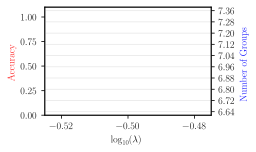

In [7]:
classifier.plot();

In [17]:
regularizers = np.geomspace(0.01, 1, 25)
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 10000, states_subset=[0,1], states_names=["Low", 'Hi'])
pruned_classifier = classifier.prune(10**(-0.5))
pruned_classifier.compute(regularizers, max_iter= 10000)

Optimizing Lasso Estimator: 100%|██████████| 25/25 [00:01<00:00, 15.19it/s]


Accuracy: 1.0%
State Low:
[81.367%]  HB_DIST LYS15-O -- ASN24-N
[6.905% ]  HB_DIST THR11-O -- ARG20-NEs
[4.319% ]  HB_DIST THR32-N -- ARG39-O
[3.667% ]  HB_DIST ARG39-N -- ARG42-N
[3.168% ]  HB_DIST ARG39-O -- ARG42-N
[0.57%  ]  HB_DIST ARG17-NEs -- GLN31-OE1s
[0.002% ]  HB_DIST THR11-N -- ARG39-N
[0.0%   ]  HB_DIST THR11-OG1s -- ARG39-O
State Hi:
[81.367%]  HB_DIST LYS15-O -- ASN24-N
[6.905% ]  HB_DIST THR11-O -- ARG20-NEs
[4.319% ]  HB_DIST THR32-N -- ARG39-O
[3.667% ]  HB_DIST ARG39-N -- ARG42-N
[3.168% ]  HB_DIST ARG39-O -- ARG42-N
[0.57%  ]  HB_DIST ARG17-NEs -- GLN31-OE1s
[0.002% ]  HB_DIST THR11-N -- ARG39-N
[0.0%   ]  HB_DIST THR11-OG1s -- ARG39-O


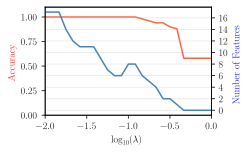

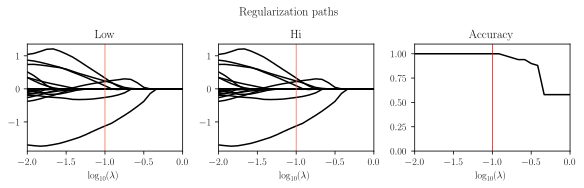

In [20]:
reg = 10**(-0.75)
pruned_classifier.print_selected(reg)
pruned_classifier.plot();
pruned_classifier.plot_regularization_path(reg);

In [18]:
classifier.prune(reg)
classifier.compute(regularizers, max_iter = 10000)

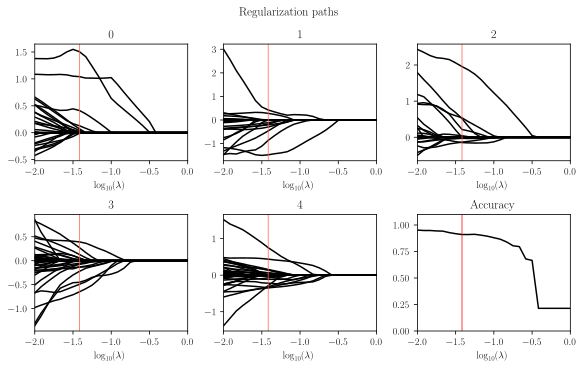

In [19]:
classifier.plot(reg);

In [20]:
classifier.prune(reg)
classifier.compute(regularizers, max_iter = 10000, quadratic_kernel=True)

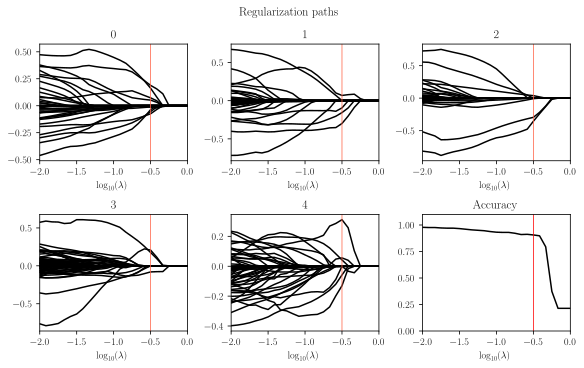

In [22]:
reg = 10**(-0.5)
classifier.plot(reg);